<a href="https://colab.research.google.com/github/eBvel/Diagnosis_of_pneumonia/blob/main/Diagnosis_of_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Диагностика пневмонии по рентгенографии
**Описание набора данных**

Набор [данных](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download) представлен в трех папках  (train, test, val) и содержит вложенные папки для каждой категории изображений (Pneumonia/Normal), в каждой из которых имеются рентгеновские снимки грудной клетки. Рентгенографии разделяются на две категории: нормальная и пневмония.

In [ ]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix

DATASET
1. Поключаемся к Google Диску, для получения данных.
2. Проводим первичный анализ.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
map_label_id = {"NORMAL": 0, "PNEUMONIA": 1}
X, y = {"train": [], "val": [], "test": []}, {"train": [], "val": [], "test": []}
dim = (224,224)
for split in X.keys():
    split_p = Path("/content/drive/MyDrive/chest_xray/") / split
    for label_p in split_p.iterdir():
        for img_p in tqdm(label_p.iterdir()):
            img = cv2.imread(str(img_p))

            try:
              img=cv2.resize(img, dim)
            except Exception as e:
              print(str(e))
            
            X[split].append(img)
            y[split].append(map_label_id[label_p.name])
    X[split] = np.stack(X[split])
    y[split] = to_categorical(np.array(y[split]))

3875it [02:15, 28.56it/s]
1341it [01:13, 18.30it/s]
8it [00:02,  3.63it/s]
8it [00:01,  4.26it/s]
390it [00:09, 39.25it/s]
234it [00:08, 27.30it/s]


In [ ]:
for split in X.keys():
    print(X[split].shape)
    print(y[split].shape)

(5216, 224, 224, 3)
(5216, 2)
(16, 224, 224, 3)
(16, 2)
(624, 224, 224, 3)
(624, 2)


[0. 1.]


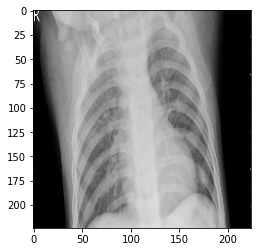

In [ ]:
print(y["train"][0])
plt.imshow(X["train"][0])

[1. 0.]


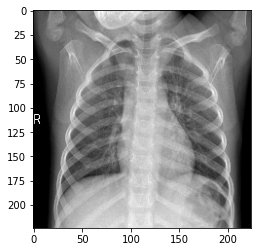

In [ ]:
print(y["train"][-1])
plt.imshow(X["train"][-1])

# Создаем модель для обучения.

*  Функция потерь: categorical_crossentropy
*  Оптимизатор: adam
*  Метркики: accuracy

> Блок с отступами



In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [ ]:
train = model.fit(X["train"], y["train"], validation_data=(X["val"], y["val"]), epochs=10, batch_size=64, verbose=1)

Epoch 1/10
82/82 [==============================] - 482s 6s/step - loss: 254.1268 - accuracy: 0.7770 - val_loss: 0.5253 - val_accuracy: 0.6875
Epoch 2/10
82/82 [==============================] - 478s 6s/step - loss: 0.4001 - accuracy: 0.8455 - val_loss: 0.4083 - val_accuracy: 0.8125
Epoch 3/10
82/82 [==============================] - 478s 6s/step - loss: 0.2865 - accuracy: 0.8898 - val_loss: 0.5877 - val_accuracy: 0.6875
Epoch 4/10
82/82 [==============================] - 479s 6s/step - loss: 0.2707 - accuracy: 0.9030 - val_loss: 0.8757 - val_accuracy: 0.6875
Epoch 5/10
82/82 [==============================] - 480s 6s/step - loss: 0.3090 - accuracy: 0.8783 - val_loss: 0.8318 - val_accuracy: 0.5625
Epoch 6/10
82/82 [==============================] - 478s 6s/step - loss: 0.2509 - accuracy: 0.9018 - val_loss: 0.7156 - val_accuracy: 0.6250
Epoch 7/10
82/82 [==============================] - 482s 6s/step - loss: 0.2147 - accuracy: 0.9139 - val_loss: 0.8800 - val_accuracy: 0.6875
Epoch 8/10


In [ ]:
scores = model.evaluate(X["test"], y["test"], verbose=0)
scores

[1.2502318620681763, 0.7596153616905212]

# Построение кривых валидации и обучения

In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

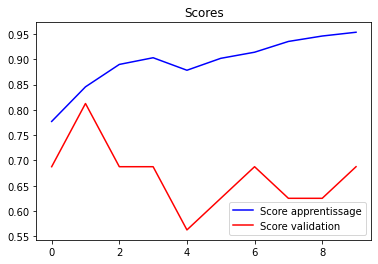

In [ ]:
plot_scores(train)

In [ ]:
y_cnn = model.predict(X["test"])
pred = y_cnn.shape
pred
y_cnn

array([[1.03376574e-20, 1.00000000e+00],
       [5.46997547e-01, 4.53002483e-01],
       [9.72885537e-05, 9.99902725e-01],
       ...,
       [6.40815616e-01, 3.59184355e-01],
       [7.10854173e-01, 2.89145797e-01],
       [1.06472194e-01, 8.93527806e-01]], dtype=float32)

In [ ]:
y_cnn = y_cnn.argmax(axis=1)
y_cnn

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
cm = confusion_matrix(y_cnn, y["test"].argmax(axis=1))
print(cm)

[[ 96  12]
 [138 378]]


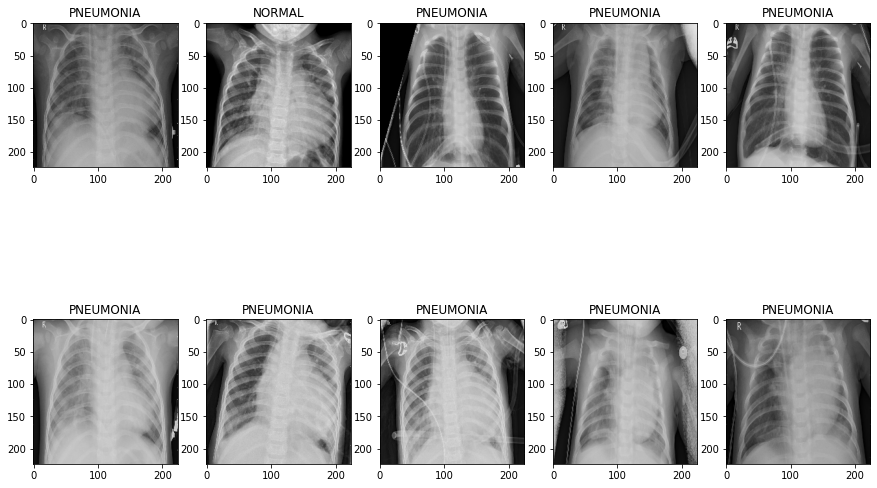

In [ ]:
id_to_label = ["NORMAL", "PNEUMONIA"]
plt.figure(figsize=(15, 10))
i = 1
for j in range(len(X["test"])) :
    if (i <= 10):
        plt.subplot(2, 5, i)
        plt.imshow(X["test"][j])
        plt.title(id_to_label[y_cnn[j]])
        i+=1